In [1]:
import os
import librosa
import librosa.display
import json 
import importlib
import formExtractor as fem
importlib.reload(fem)

<module 'formExtractor' from '/home/dalmazzo/ai_music_form/src/formExtractor.py'>

In [2]:
import numpy as np
np.version.version

'2.0.2'

In [3]:
def load_audio_files(path):
    audio_files = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(".mp3"):
                audio_files.append(os.path.join(root, file))
    return audio_files

In [4]:
path = '/home/laura/aimir/'
collection = 'suno' #lastfm, suno, udio
song_files = path + collection + '/audio'
files = load_audio_files(song_files)
print(len(files))

83778


In [5]:
myFiles = files[:20]

In [6]:
id = 5
song = myFiles[id]

#song = '/home/laura/aimir/boomy/audio/14065870.mp3'
id_file = song.split('/')[-1].split('.')[0]

In [7]:
# print metadata
md = path + collection + '/metadata/' + id_file + '.json'

with open(md) as json_file:
    data = json.load(json_file)
    
    # Calculate the maximum key length
    max_key_length = max(len(key) for key in data.keys())
    
    # Print each line with keys aligned
    for key in data:
        print(f"{key:{max_key_length}} : {data[key]}")

id                           : 000364ba-26f7-44d5-9698-b75e322dc8a1
video_url                    : https://cdn1.suno.ai/000364ba-26f7-44d5-9698-b75e322dc8a1.mp4
audio_url                    : https://cdn1.suno.ai/000364ba-26f7-44d5-9698-b75e322dc8a1.mp3
image_url                    : https://cdn1.suno.ai/image_000364ba-26f7-44d5-9698-b75e322dc8a1.png
image_large_url              : https://cdn1.suno.ai/image_large_000364ba-26f7-44d5-9698-b75e322dc8a1.png
is_video_pending             : False
major_model_version          : v3.5
model_name                   : chirp-v3
is_liked                     : False
user_id                      : af2c08f1-9985-4e0d-8566-971a2f157fa3
display_name                 : ChartToppingSampler999
handle                       : charttoppingsampler999
is_handle_updated            : False
avatar_image_url             : None
is_trashed                   : False
reaction                     : None
created_at                   : 2024-06-24T13:28:28.653Z
status        

In [8]:
formData = fem.formExtractor()

y, sr = librosa.load(song)

In [9]:
import numpy as np

# Extract chroma features
chroma = librosa.feature.chroma_stft(y=y, sr=sr)
# Aggregate chroma features by averaging over time
chroma_mean = np.mean(chroma, axis=1)


In [10]:
# Krumhansl-Schmuckler key profiles
major_profile = np.array([6.35, 2.23, 3.48, 2.33, 4.38, 4.09, 2.52,
                          5.19, 2.39, 3.66, 2.29, 2.88])

minor_profile = np.array([6.33, 2.68, 3.52, 5.38, 2.60, 3.53, 2.54,
                          4.75, 3.98, 2.69, 3.34, 3.17])


In [11]:
# Function to compute correlation
def compute_correlation(chroma_vector, key_profile):
    return np.corrcoef(chroma_vector, key_profile)[0, 1]

# Initialize lists to store correlation scores
correlations = []

# Iterate over all 12 keys
keys = ['C', 'C#', 'D', 'D#', 'E', 'F',
        'F#', 'G', 'G#', 'A', 'A#', 'B']
modes = ['major', 'minor']

for i, key in enumerate(keys):
    # Rotate the key profiles to match the current key
    rotated_major = np.roll(major_profile, i)
    rotated_minor = np.roll(minor_profile, i)
    
    # Compute correlations
    corr_major = compute_correlation(chroma_mean, rotated_major)
    corr_minor = compute_correlation(chroma_mean, rotated_minor)
    
    correlations.append((f"{key} major", corr_major))
    correlations.append((f"{key} minor", corr_minor))

# Sort keys by correlation score
correlations.sort(key=lambda x: x[1], reverse=True)

# Print top 5 key suggestions
print("Top 5 key detections:")
for key, score in correlations[:5]:
    print(f"{key}: {score:.4f}")

#get the first tonality in the list
tonality = correlations[0][0]


Top 5 key detections:
C# minor: 0.7184
E major: 0.7101
G# minor: 0.5827
B major: 0.5202
F# major: 0.4263


In [12]:
C = formData.amplitud_to_db(y, sr, False)

In [13]:
#Example 1, calculate all the features and save them

#path = '/home/laura/aimir/suno/form/'
#K = 6
#data_dict = formData.getFormAndSave(K, song, id_file, path)

# Call the plotSpectrogram function
#plotMe.plotSpectrogram(sr, C, chords, bars, bound_frames, new_bound_segs, BINS_PER_OCTAVE, 40, 5)

#plotMe.plotWaveform(y, data_dict['sr'], data_dict['chords'], data_dict['bars'], data_dict['bound_frames'], data_dict['bound_segs'], 40, 5) #last two numbers are the size of the plot in inches

#from IPython.display import Audio
#Audio(song)

In [14]:
Csync, beats, beat_times = formData.sync(y, sr, C)

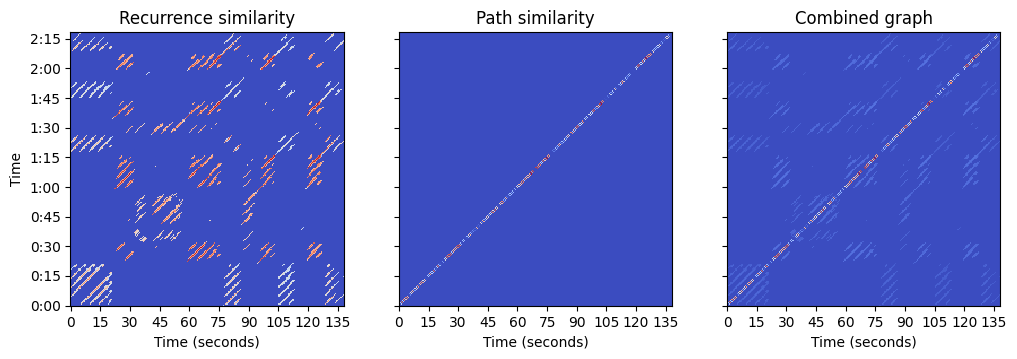

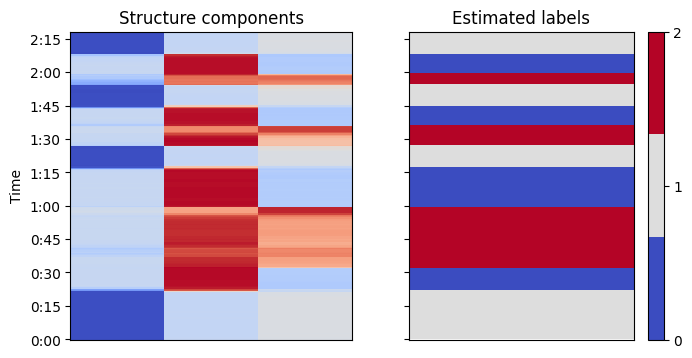

In [15]:
K = 3 #If we want k clusters, use the first k normalized eigenvectors.
bound_frames, bound_segs = formData.laplacian(y, sr, C, Csync, beats, beat_times, K, True) #True to plot the laplacian

In [16]:
chord_progression = formData.getChords(song)
bars = formData.getBars(song)

data_dict = formData.populateDict(sr, chord_progression, bars, bound_frames, bound_segs, )

In [17]:
print(chord_progression)

[ChordChange(chord='N', timestamp=0.371519274), ChordChange(chord='C#m', timestamp=0.464399092), ChordChange(chord='A', timestamp=1.207437641), ChordChange(chord='E', timestamp=2.60063492), ChordChange(chord='B', timestamp=3.7151927430000002), ChordChange(chord='C#m', timestamp=4.922630385), ChordChange(chord='F#m', timestamp=5.851428571), ChordChange(chord='E', timestamp=6.965986394), ChordChange(chord='C#m', timestamp=9.19510204), ChordChange(chord='A6', timestamp=10.402539682), ChordChange(chord='E', timestamp=11.795736961), ChordChange(chord='C#m', timestamp=13.746213151), ChordChange(chord='F#m', timestamp=15.046530612), ChordChange(chord='E', timestamp=16.346848072), ChordChange(chord='B', timestamp=17.368526077), ChordChange(chord='A', timestamp=18.4830839), ChordChange(chord='B', timestamp=20.712199546), ChordChange(chord='C#m', timestamp=22.755555555), ChordChange(chord='A', timestamp=24.241632653), ChordChange(chord='E', timestamp=25.356190476), ChordChange(chord='B', timesta

In [18]:
#get the name of folder where the data will be saved
myFolder = os.getcwd().split('src')[0]
thisPath = myFolder + collection + '/'
formData.saveData(data_dict, id_file, thisPath)

Plot the Song Form

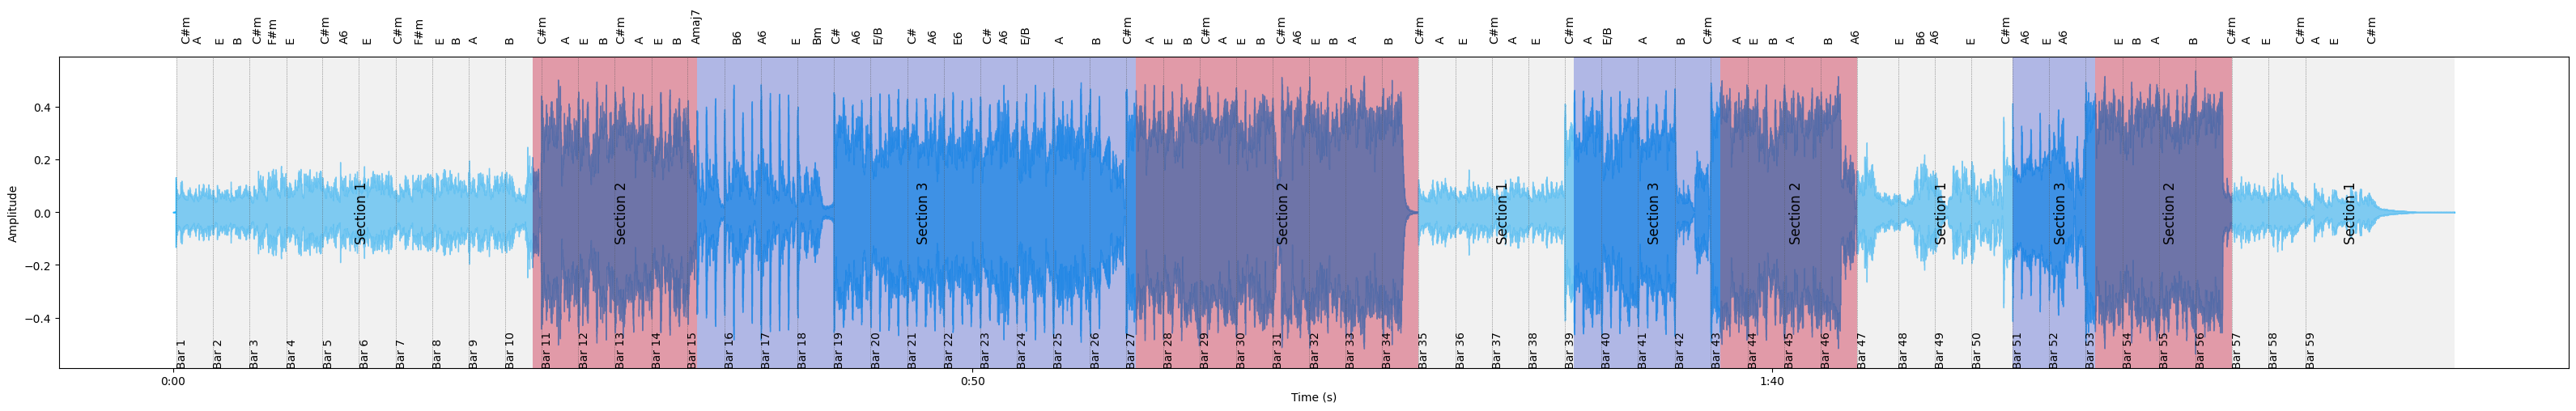

In [19]:
import plotMe
importlib.reload(plotMe)

# Call the plotSpectrogram function
#plotMe.plotSpectrogram(sr, C, chords, bars, bound_frames, new_bound_segs, BINS_PER_OCTAVE, 40, 5)

plotMe.plotWaveform(y, data_dict['sr'], data_dict['chords'], data_dict['bars'], data_dict['bound_frames'], data_dict['bound_segs'], 40, 5, 'coolwarm') #last two numbers are the size of the plot in inches

from IPython.display import Audio
Audio(song)

In [20]:
#The array contains a dictionary [ChordChange(chord='N', timestamp=0.371519274), ChordChange(chord='C#m', timestamp=0.464399092), print only the chord
print([chord.chord for chord in chord_progression])

['N', 'C#m', 'A', 'E', 'B', 'C#m', 'F#m', 'E', 'C#m', 'A6', 'E', 'C#m', 'F#m', 'E', 'B', 'A', 'B', 'C#m', 'A', 'E', 'B', 'C#m', 'A', 'E', 'B', 'Amaj7', 'B6', 'A6', 'E', 'Bm', 'C#', 'A6', 'E/B', 'C#', 'A6', 'E6', 'C#', 'A6', 'E/B', 'A', 'B', 'C#m', 'A', 'E', 'B', 'C#m', 'A', 'E', 'B', 'C#m', 'A6', 'E', 'B', 'A', 'B', 'C#m', 'A', 'E', 'C#m', 'A', 'E', 'C#m', 'A', 'E/B', 'A', 'B', 'C#m', 'A', 'E', 'B', 'A', 'B', 'A6', 'E', 'B6', 'A6', 'E', 'C#m', 'A6', 'E', 'A6', 'E', 'B', 'A', 'B', 'C#m', 'A', 'E', 'C#m', 'A', 'E', 'C#m', 'N']


In [21]:
#print the chords only
thisChord = [chord.chord for chord in chord_progression]
thisTimestamp = [chord.timestamp for chord in chord_progression]
print(thisChord)
print(thisTimestamp)

['N', 'C#m', 'A', 'E', 'B', 'C#m', 'F#m', 'E', 'C#m', 'A6', 'E', 'C#m', 'F#m', 'E', 'B', 'A', 'B', 'C#m', 'A', 'E', 'B', 'C#m', 'A', 'E', 'B', 'Amaj7', 'B6', 'A6', 'E', 'Bm', 'C#', 'A6', 'E/B', 'C#', 'A6', 'E6', 'C#', 'A6', 'E/B', 'A', 'B', 'C#m', 'A', 'E', 'B', 'C#m', 'A', 'E', 'B', 'C#m', 'A6', 'E', 'B', 'A', 'B', 'C#m', 'A', 'E', 'C#m', 'A', 'E', 'C#m', 'A', 'E/B', 'A', 'B', 'C#m', 'A', 'E', 'B', 'A', 'B', 'A6', 'E', 'B6', 'A6', 'E', 'C#m', 'A6', 'E', 'A6', 'E', 'B', 'A', 'B', 'C#m', 'A', 'E', 'C#m', 'A', 'E', 'C#m', 'N']
[0.371519274, 0.464399092, 1.207437641, 2.60063492, 3.7151927430000002, 4.922630385, 5.851428571, 6.965986394, 9.19510204, 10.402539682, 11.795736961, 13.746213151, 15.046530612, 16.346848072, 17.368526077, 18.4830839, 20.712199546, 22.755555555, 24.241632653, 25.356190476, 26.563628117, 27.678185941, 28.885623582, 30.000181405, 31.207619047, 32.415056689, 34.922811791, 36.594648526, 38.638004535, 39.938321995, 41.145759637, 42.446077097, 43.746394557, 45.882630385

In [22]:
#plotMe.plotSections(y, data_dict['sr'], data_dict['chords'], data_dict['bars'], data_dict['bound_frames'], data_dict['bound_segs'], 20, 5, 64) #20 and 5 are the size of the plot in inches, and 32 is the number of bars to plot

In [23]:
#plotMe.plotChordsBars(data_dict['chords'], data_dict['bars'], data_dict['bound_frames'], data_dict['bound_segs'])

In [34]:
from music21 import harmony, roman, key

# Define the key context explicitly as C major
mykey = tonality.split(' ')[0]
mymode = tonality.split(' ')[1]
song_key = key.Key(mykey, mymode)
print(f"Key: {song_key.tonic.name} {song_key.mode}")

# Modified chord progression with explicit minor notation
progression = ['C', 'G', 'Am', 'Em']


#The array contains a dictionary [ChordChange(chord='N', timestamp=0.371519274), ChordChange(chord='C#m', timestamp=0.464399092), save the tuple with the function and its location in the timestamp
functional_harmony = []

for chord_name, timestamp in zip(thisChord, thisTimestamp):
    if chord_name == 'N':
        # Skip any chords labeled as N
        functional_harmony.append(('N', timestamp))
        continue
    else:   
        # Create a ChordSymbol object to correctly interpret chord qualities
        chord_symbol = harmony.ChordSymbol(chord_name)
        
        # Convert the chord symbol to a Roman numeral based on the key
        roman_numeral = roman.romanNumeralFromChord(chord_symbol, song_key)
     
        # Append the Roman numeral and timestamp to the list
        functional_harmony.append((roman_numeral.figure, timestamp))
   
print(functional_harmony)

from IPython.display import Audio
Audio(song)

Key: C# minor


[('N', 0.371519274), ('i', 0.464399092), ('bVI', 1.207437641), ('III', 2.60063492), ('bVII', 3.7151927430000002), ('i', 4.922630385), ('iv', 5.851428571), ('III', 6.965986394), ('i', 9.19510204), ('bVI65', 10.402539682), ('III', 11.795736961), ('i', 13.746213151), ('iv', 15.046530612), ('III', 16.346848072), ('bVII', 17.368526077), ('bVI', 18.4830839), ('bVII', 20.712199546), ('i', 22.755555555), ('bVI', 24.241632653), ('III', 25.356190476), ('bVII', 26.563628117), ('i', 27.678185941), ('bVI', 28.885623582), ('III', 30.000181405), ('bVII', 31.207619047), ('bVI7', 32.415056689), ('bVII65', 34.922811791), ('bVI65', 36.594648526), ('III', 38.638004535), ('bvii', 39.938321995), ('I', 41.145759637), ('bVI65', 42.446077097), ('III64', 43.746394557), ('I', 45.882630385), ('bVI65', 47.182947845), ('III65', 48.761904761), ('I', 50.619501133), ('bVI65', 51.641179138), ('III64', 52.941496598), ('bVI', 55.170612244), ('bVII', 57.399727891), ('i', 59.350204081), ('bVI', 60.836281179), ('III', 61.95

Detected Keys with Temporal Consistency:
Time 0.00s: E major (strength: 0.8577)
Time 5.00s: E major (strength: 0.8433)
Time 10.00s: E major (strength: 0.8630)
Time 15.00s: E major (strength: 0.7348)
Time 20.00s: E major (strength: 0.7062)
Time 25.00s: E major (strength: 0.8464)
Time 30.00s: E major (strength: 0.7113)
Time 35.00s: E major (strength: 0.6566)
Time 40.00s: E major (strength: 0.7776)
Time 45.00s: E major (strength: 0.8372)
Time 50.00s: E major (strength: 0.7258)
Time 55.00s: E major (strength: 0.7733)
Time 60.00s: E major (strength: 0.8930)
Time 65.00s: E major (strength: 0.8048)
Time 70.00s: E major (strength: 0.7799)
Time 75.00s: E major (strength: 0.8586)
Time 80.00s: E major (strength: 0.9530)
Time 85.00s: E major (strength: 0.7657)
Time 90.00s: E major (strength: 0.6705)
Time 95.00s: E major (strength: 0.6933)
Time 100.00s: E major (strength: 0.7844)
Time 105.00s: E major (strength: 0.8615)
Time 110.00s: E major (strength: 0.8331)
Time 115.00s: E major (strength: 0.764

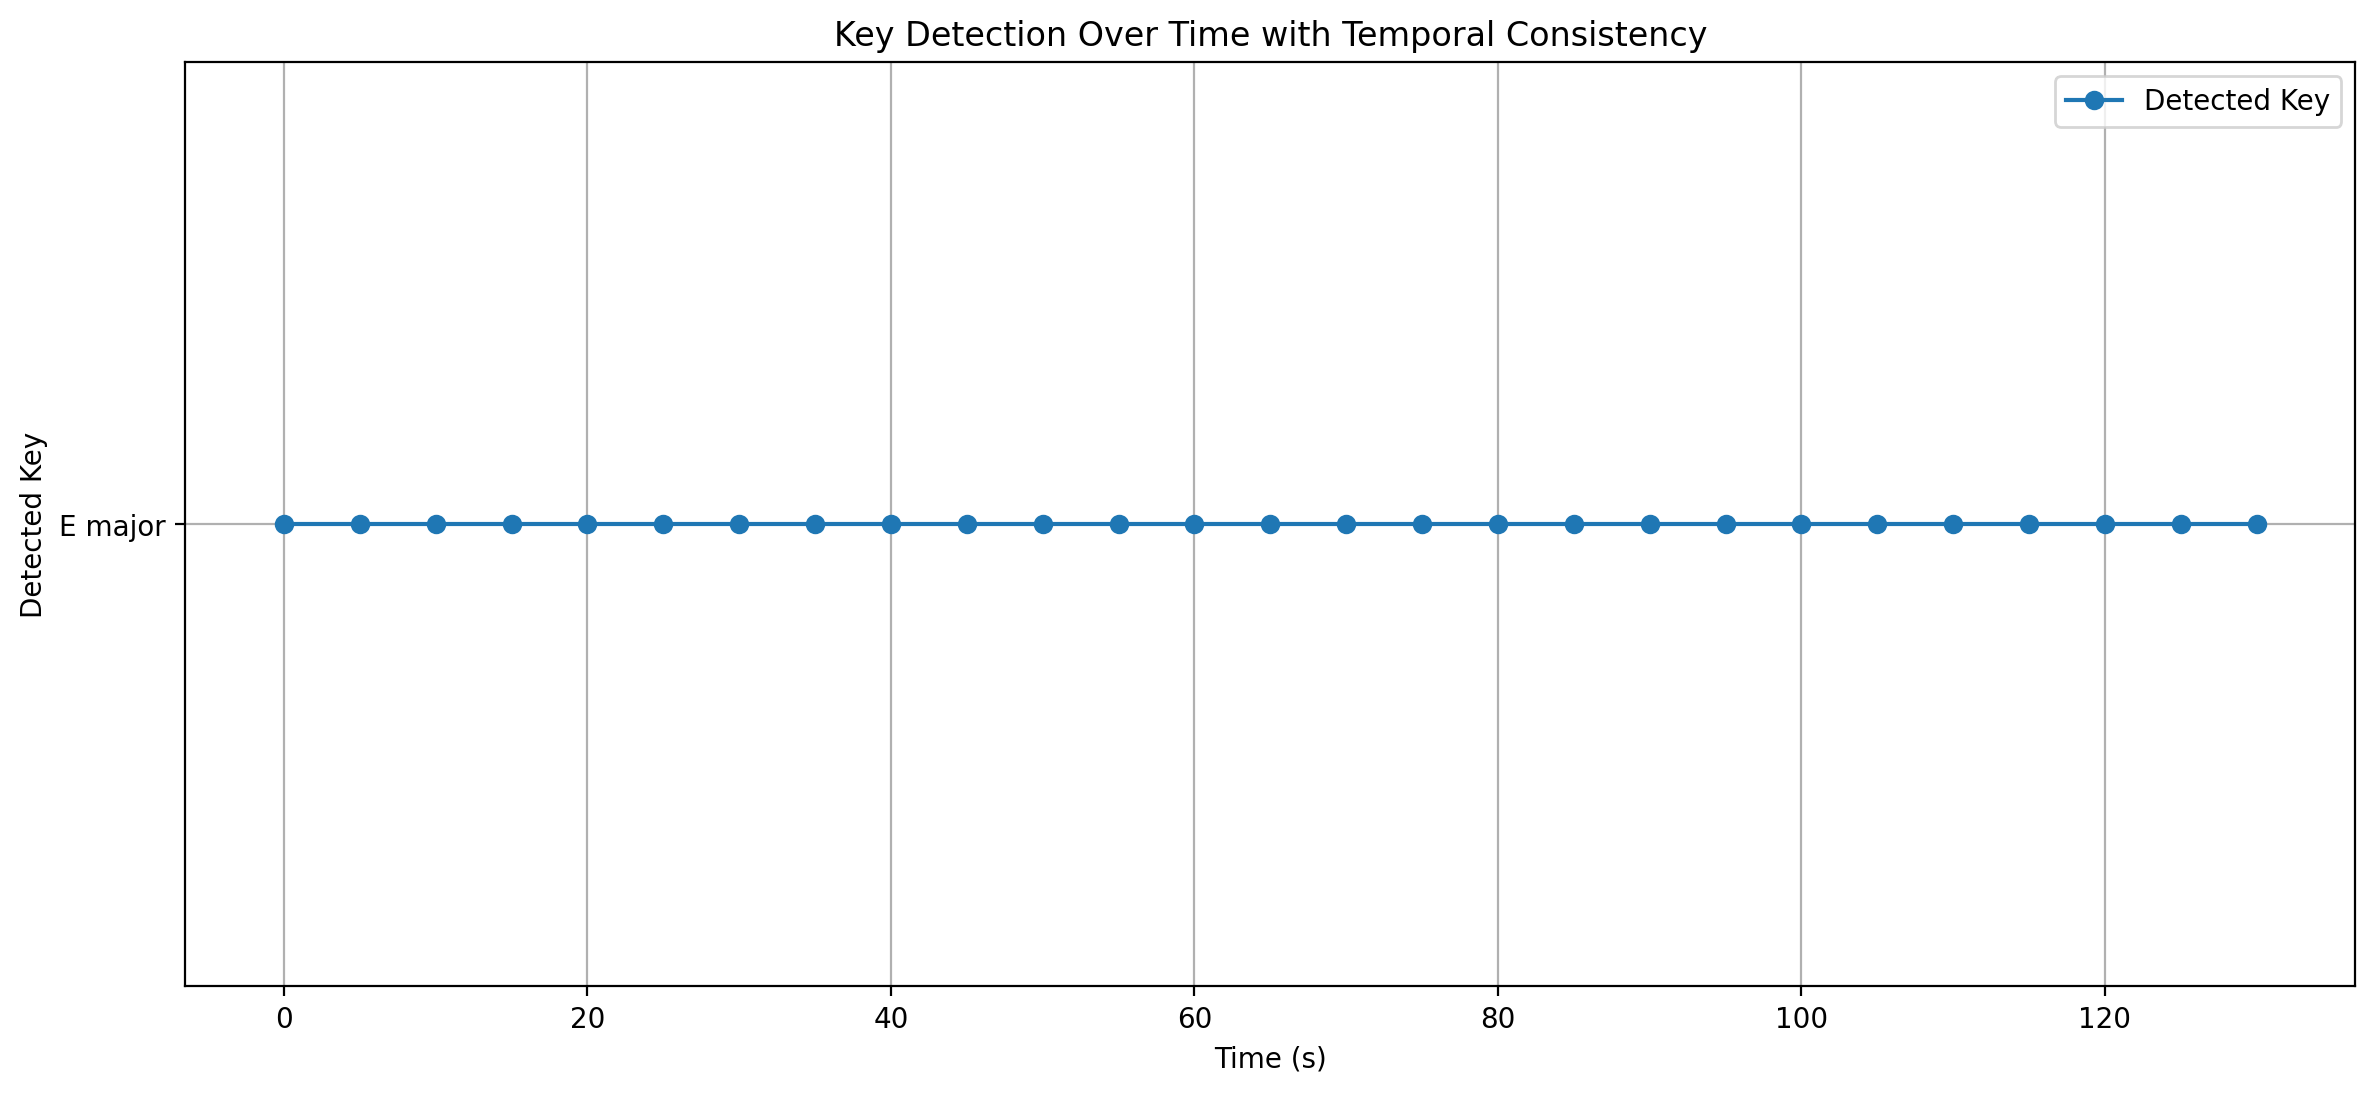

In [38]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

# Path to your audio file
audio_path = song  # Replace with your actual file path

# Load the audio file
y, sr = librosa.load(audio_path)

# Define window size and hop length (in seconds)
window_size = 10.0  # seconds (you can experiment with different sizes)
hop_length = 5.0     # seconds (you can experiment with different hop lengths)

# Convert window and hop lengths to samples
window_length = int(window_size * sr)
hop_length_samples = int(hop_length * sr)

# Define Krumhansl-Schmuckler key profiles and normalize
major_profile = np.array([6.35, 2.23, 3.48, 2.33, 4.38, 4.09,
                          2.52, 5.19, 2.39, 3.66, 2.29, 2.88])
minor_profile = np.array([6.33, 2.68, 3.52, 5.38, 2.60, 3.53,
                          2.54, 4.75, 3.98, 2.69, 3.34, 3.17])

# Normalize key profiles to unit vectors
major_profile /= np.linalg.norm(major_profile)
minor_profile /= np.linalg.norm(minor_profile)

keys = ['C', 'C#', 'D', 'D#', 'E', 'F',
        'F#', 'G', 'G#', 'A', 'A#', 'B']
modes = ['major', 'minor']

# Function to compute correlation
def compute_correlation(chroma_vector, key_profile):
    return np.corrcoef(chroma_vector, key_profile)[0, 1]

# Initialize lists to store results
segment_times = []
detected_keys = []
detected_strengths = []

# Iterate over the audio in windows
for start in range(0, len(y) - window_length + 1, hop_length_samples):
    end = start + window_length
    window_audio = y[start:end]
    
    # Extract chroma features using CQT
    chroma = librosa.feature.chroma_cqt(y=window_audio, sr=sr)
    chroma_mean = np.mean(chroma, axis=1)
    
    # Normalize chroma vector to unit vector
    if np.linalg.norm(chroma_mean) == 0:
        chroma_norm = chroma_mean
    else:
        chroma_norm = chroma_mean / np.linalg.norm(chroma_mean)
    
    correlations = []
    
    for i, key in enumerate(keys):
        # Rotate the key profiles to match the current key
        rotated_major = np.roll(major_profile, i)
        rotated_minor = np.roll(minor_profile, i)
        
        # Compute correlations
        corr_major = compute_correlation(chroma_norm, rotated_major)
        corr_minor = compute_correlation(chroma_norm, rotated_minor)
        
        correlations.append((f"{key} major", corr_major))
        correlations.append((f"{key} minor", corr_minor))
    
    # Sort keys by correlation score
    correlations.sort(key=lambda x: x[1], reverse=True)
    
    # Get the top key
    top_key, top_score = correlations[0]
    
    # Store the results
    segment_times.append(start / sr)
    detected_keys.append(top_key)
    detected_strengths.append(top_score)

# Implement temporal consistency with majority voting
consensus_window = 2  # Number of consecutive windows to confirm a key
recent_keys = deque(maxlen=consensus_window)
final_detected_keys = []
current_key = detected_keys[0]

for key in detected_keys:
    recent_keys.append(key)
    if len(recent_keys) == consensus_window and all(k == recent_keys[0] for k in recent_keys):
        current_key = recent_keys[0]
    final_detected_keys.append(current_key)

# Print the detected keys for each segment
print("Detected Keys with Temporal Consistency:")
for time, key, strength in zip(segment_times, final_detected_keys, detected_strengths):
    print(f"Time {time:.2f}s: {key} (strength: {strength:.4f})")

# Visualization
plt.figure(figsize=(14, 6))
plt.plot(segment_times, final_detected_keys, marker='o', linestyle='-', label='Detected Key')
plt.xlabel('Time (s)')
plt.ylabel('Detected Key')
plt.title('Key Detection Over Time with Temporal Consistency')
plt.grid(True)
plt.legend()
plt.show()
